In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


In [ ]:
def get_relevant_indices(dataset, classes, target_classes):
    
    indices = []
    for i in range(len(dataset)):
       
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
   
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
  
    relevant_train_indices = get_relevant_indices(
            trainset,
            classes,
            target_classes)
  
    np.random.seed(1000) 
    np.random.shuffle(relevant_train_indices)
    split = int(len(relevant_train_indices) * 0.8)
    relevant_train_indices, relevant_val_indices = relevant_train_indices[:split], relevant_train_indices[split:]
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

  
def evaluate(net, loader, criterion):
    
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
 
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# download dataset
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1)

0it [00:00, ?it/s]

100%|█████████▉| 170311680/170498071 [00:16<00:00, 9487236.62it/s]

Files already downloaded and verified


1-A

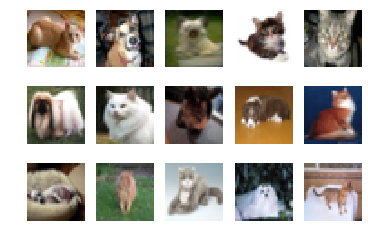

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

1-B

In [ ]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

8000
2000
2000


1-C :  We need a validation set when training our model because the validation set is not used to train the model, so that it will test the model to see if it is actually accurate or it's memorizing the dataset that was used to train it. By using training set loss/error instead of the validation set loss/error, we will likely judge the model to have a great performance and accuracy. However, this accuracy only indicates the accuracy of the model predicting on the training data, and will likely to have a relatively poor performance if other test data is used.

2-A

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x
      
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x
      
small_net = SmallNet()
large_net = LargeNet()

for param in small_net.parameters():
    print(param.shape)
print(" ---------------")   
for param in large_net.parameters():
    print(param.shape)
print("small net has {} parameters".format(5*3*3*3+5*1+1*245+1*1))
print("large net has {} parameters".format(5*3*5*5+5*1+10*5*5*5+10*1+32*250+32*1+32+1))

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
 ---------------
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
small net has 386 parameters
large net has 9705 parameters


2-B

In [ ]:
def train_net(net, batch_size=128, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

Default batch_size = 64, learning_rate = 0.01, num_epochs = 30

2-C  

Answer: Files written to disk:

Train error: the error rate that was calculated by using the training data for each epoch.

train loss: This is the train loss estimated by the Binary cross entropy function using the training data set for each epoch

validation error: the error rate that was calculated by using the validation data set for each epoch. ( to test on the trained model)

validation loss: This is the validation loss estimated by the Binary cross entropy function using the validation data set for each epoch

In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43725, Train loss: 0.6801570100784302 |Validation err: 0.3715, Validation loss: 0.656835999339819
Epoch 2: Train err: 0.374625, Train loss: 0.6510570149421692 |Validation err: 0.38, Validation loss: 0.6545183956623077
Epoch 3: Train err: 0.35625, Train loss: 0.637815809726715 |Validation err: 0.346, Validation loss: 0.6267593521624804
Epoch 4: Train err: 0.3455, Train loss: 0.6215695919990539 |Validation err: 0.3645, Validation loss: 0.6240927260369062
Epoch 5: Train err: 0.330375, Train loss: 0.6059077157974243 |Validation err: 0.3355, Validation loss: 0.6096588764339685
Finished Training
Total time elapsed: 15.33 seconds


2-D

Answer:

large_net spent more training time. The reason is because the untrained large_net model contains a larger number of parameters, so that the training process for each epoch will take longer.

In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.324875, Train loss: 0.6056860909461975 |Validation err: 0.3305, Validation loss: 0.6132436618208885
Epoch 2: Train err: 0.324125, Train loss: 0.5956838607788086 |Validation err: 0.3305, Validation loss: 0.6124046631157398
Epoch 3: Train err: 0.306375, Train loss: 0.5898056144714355 |Validation err: 0.3165, Validation loss: 0.6019327733665705
Epoch 4: Train err: 0.311125, Train loss: 0.5843449964523315 |Validation err: 0.343, Validation loss: 0.6142618991434574
Epoch 5: Train err: 0.30175, Train loss: 0.5780326297283173 |Validation err: 0.3065, Validation loss: 0.5962394662201405
Epoch 6: Train err: 0.29775, Train loss: 0.5723183550834656 |Validation err: 0.3075, Validation loss: 0.6000219406560063
Epoch 7: Train err: 0.29725, Train loss: 0.5731415419578553 |Validation err: 0.3125, Validation loss: 0.5921629704535007
Epoch 8: Train err: 0.297, Train loss: 0.5652911431789398 |Validation err:

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.448375, Train loss: 0.6869223680496216 |Validation err: 0.416, Validation loss: 0.6736730877310038
Epoch 2: Train err: 0.398875, Train loss: 0.6668018898963928 |Validation err: 0.4015, Validation loss: 0.6672572381794453
Epoch 3: Train err: 0.377, Train loss: 0.6497031750679017 |Validation err: 0.3565, Validation loss: 0.6311277914792299
Epoch 4: Train err: 0.35575, Train loss: 0.6310481944084168 |Validation err: 0.3465, Validation loss: 0.6232962571084499
Epoch 5: Train err: 0.339125, Train loss: 0.6172202293872833 |Validation err: 0.323, Validation loss: 0.616951422765851
Epoch 6: Train err: 0.32625, Train loss: 0.6030436732769012 |Validation err: 0.315, Validation loss: 0.6074441932141781
Epoch 7: Train err: 0.319875, Train loss: 0.5936636271476745 |Validation err: 0.326, Validation loss: 0.6045441273599863
Epoch 8: Train err: 0.309375, Train loss: 0.5771227416992187 |Validation err: 0.

2-E

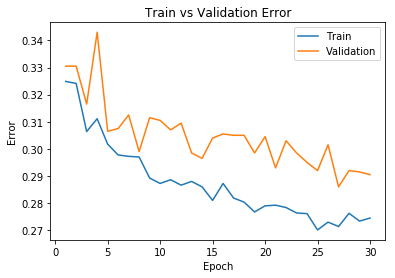

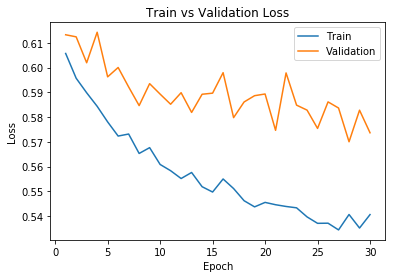

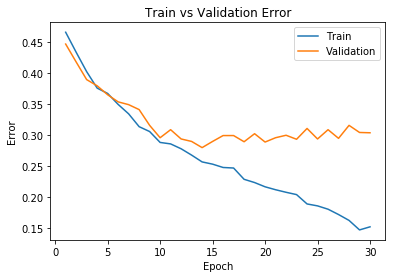

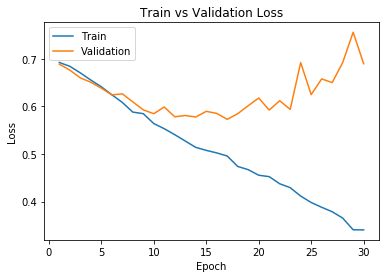

In [ ]:
model_path_small = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_small)
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

2-F

Answer: 

Training curve: The loss/error of the training curve is almost always lower than its validation curve for both large_net and small_net. The error/loss reduces over the course of the training process/number of epochs.

differences between small_net and large_net curves: 

1. large_net has a lower training error/loss on the training curve after the training process, compared to small_net
2. small_net has  a lower validation error/loss at the end of the traing process, compared to large_net
3. small_net curves introduces relatively apparent fluctuations, as compared to large_net

Overfitting/Underfitting:

For small_net, there is no apparent overfitting based on the graph, but this could be considered as under fitting since the validation error/loss generally kept decreasing over the 30 epochs

For large_net, the overfitting occurs at around 13 epochs since the validation error/loss stops decreasing and starts to going up.

In [ ]:
large_net = LargeNet()
train_net(large_net)

0it [00:00, ?it/s]

170500096it [00:40, 5082132.16it/s]                               

Files already downloaded and verified
Epoch 1: Train err: 0.496125, Train loss: 0.6934515550023034 |Validation err: 0.4595, Validation loss: 0.6924455501139164
Epoch 2: Train err: 0.460125, Train loss: 0.6918713090911744 |Validation err: 0.423, Validation loss: 0.6906456276774406
Epoch 3: Train err: 0.42325, Train loss: 0.6888803177409701 |Validation err: 0.42, Validation loss: 0.6847805790603161
Epoch 4: Train err: 0.410875, Train loss: 0.6806997458140055 |Validation err: 0.408, Validation loss: 0.6716213226318359
Epoch 5: Train err: 0.403375, Train loss: 0.6726927246366229 |Validation err: 0.395, Validation loss: 0.6641510054469109
Epoch 6: Train err: 0.392375, Train loss: 0.6649260975065685 |Validation err: 0.3875, Validation loss: 0.6584508083760738
Epoch 7: Train err: 0.378375, Train loss: 0.6563453920303829 |Validation err: 0.3835, Validation loss: 0.6477856673300266
Epoch 8: Train err: 0.372875, Train loss: 0.6468293628995381 |Validation err: 0.375, Validation loss: 0.6411580741

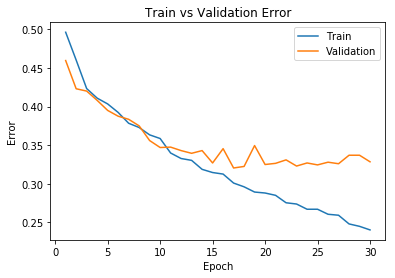

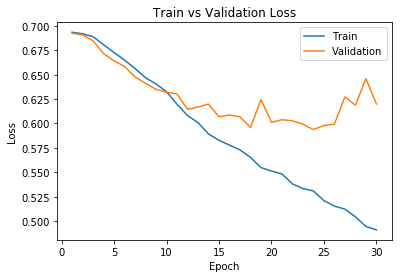

In [ ]:
model_path_large_128 = get_model_name("large", batch_size=128, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_128)

3-A @lr = 0.001  training time = 111.06s < default training time (115.27s)

Anwer: 

The model took a little bit shorter to train. By lowering the learning rate, the training and validation loss/error are higher after training, compared to the model with default hyperparameters. Since validation loss and error did not stop decreasing, it is considered underfitting. It also caused the two plots to be closer to each other.

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4895, Train loss: 0.6930576057434082 |Validation err: 0.4885, Validation loss: 0.6928847059607506
Epoch 2: Train err: 0.479, Train loss: 0.6928481736183166 |Validation err: 0.4635, Validation loss: 0.692598968744278
Epoch 3: Train err: 0.4665, Train loss: 0.6926065049171448 |Validation err: 0.455, Validation loss: 0.692399512976408
Epoch 4: Train err: 0.4535, Train loss: 0.6923558731079101 |Validation err: 0.443, Validation loss: 0.6919916942715645
Epoch 5: Train err: 0.454625, Train loss: 0.6920417928695679 |Validation err: 0.437, Validation loss: 0.6917340867221355
Epoch 6: Train err: 0.451125, Train loss: 0.6916759252548218 |Validation err: 0.4375, Validation loss: 0.6911877356469631
Epoch 7: Train err: 0.452375, Train loss: 0.6912370820045471 |Validation err: 0.4325, Validation loss: 0.6905495524406433
Epoch 8: Train err: 0.44525, Train loss: 0.6906646966934205 |Validation err: 0.4225,

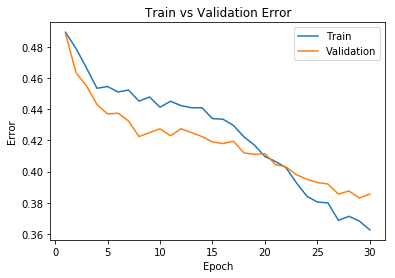

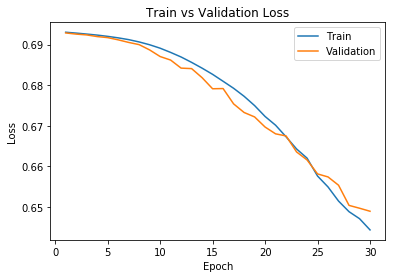

In [ ]:
model_path_large_1 = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path_large_1)

3-B @ lr = 0.1 training time = 109.25s <default training time (115.27s)

Answer: increasing the learning rate will decrease the training time slightly. By increasing the learning rate, more noise is created in the changes in loss and errors. Validation loss and error decreased to minimum sooner due to increased learning rate. 

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.426875, Train loss: 0.6742900676727295 |Validation err: 0.3695, Validation loss: 0.6364889536052942
Epoch 2: Train err: 0.361625, Train loss: 0.6373908457756042 |Validation err: 0.3655, Validation loss: 0.6439082939177752
Epoch 3: Train err: 0.371625, Train loss: 0.6370397086143493 |Validation err: 0.3515, Validation loss: 0.6133540160953999
Epoch 4: Train err: 0.348, Train loss: 0.6141975626945496 |Validation err: 0.3365, Validation loss: 0.6044933125376701
Epoch 5: Train err: 0.333875, Train loss: 0.6029216282367706 |Validation err: 0.3245, Validation loss: 0.5935317613184452
Epoch 6: Train err: 0.3175, Train loss: 0.5871682240962982 |Validation err: 0.324, Validation loss: 0.5884642750024796
Epoch 7: Train err: 0.308, Train loss: 0.5718630583286285 |Validation err: 0.3095, Validation loss: 0.5934673277661204
Epoch 8: Train err: 0.306625, Train loss: 0.5659790558815002 |Validation err: 0

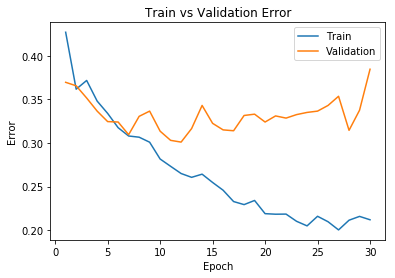

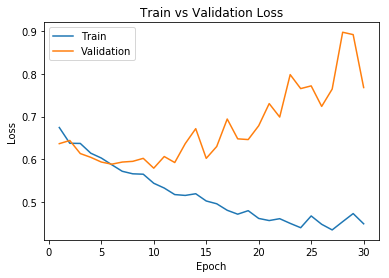

In [ ]:
model_path_large_2 = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path_large_2)

3-C@ lr=0.01, bz = 512 training time = 97.03s <default training time (115.27s)

Answer: 

Increasing the batch size will decrease the training time. By increasing the batch size, the train and validation error and loss value are larger than the default values. Also it makes the graph to be underfit. the validation curve and training curves are more close to each other.

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379403591156 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103908240795 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500441730022 |Validation err: 0.4265, Validation loss: 0.6909130066633224
Epoch 4: Train err: 0.433625, Train loss: 0.6908450052142143 |Validation err: 0.424, Validation loss: 0.6897870898246765
Epoch 5: Train err: 0.434, Train loss: 0.6896936446428299 |Validation err: 0.424, Validation loss: 0.6881358623504639
Epoch 6: Train err: 0.43825, Train loss: 0.6883534081280231 |Validation err: 0.428, Validation loss: 0.68601293861866
Epoch 7: Train err: 0.439375, Train loss: 0.6866869702935219 |Validation err: 0.426, Validation loss: 0.6836968064308167
Epoch 8: Train err: 0.435375, Train loss: 0.6849769502878189 |Validation err: 0.412, V

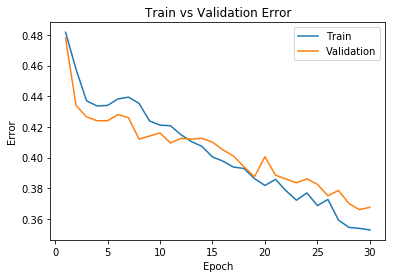

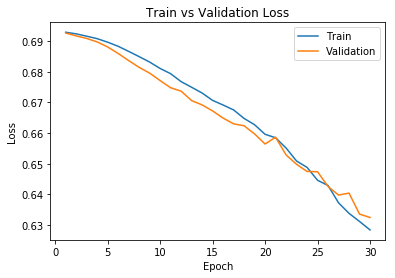

In [ ]:
model_path_large_512 = get_model_name("large", batch_size = 512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_512)

3-D lr = 0.01, bz = 16  training time = 159.71s >default training time (115.27s)

Answer: decreasing the batch size will increase the training time. By decreasing the batch size, the training error/loss are smaller than the default value after training. It makes overfit start sonner at epoch 5. Highest validation loss is larger than default value's highest validation loss.

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774821187257767 |Validation err: 0.378, Validation loss: 0.651921395778656
Epoch 2: Train err: 0.36875, Train loss: 0.6395755406022072 |Validation err: 0.3595, Validation loss: 0.6264406447410583
Epoch 3: Train err: 0.33875, Train loss: 0.6120929001569748 |Validation err: 0.3475, Validation loss: 0.6289729187488556
Epoch 4: Train err: 0.314375, Train loss: 0.5869516692757607 |Validation err: 0.3545, Validation loss: 0.6142054274082184
Epoch 5: Train err: 0.3115, Train loss: 0.5694829801917076 |Validation err: 0.312, Validation loss: 0.5763112711906433
Epoch 6: Train err: 0.281125, Train loss: 0.5458917077481746 |Validation err: 0.2985, Validation loss: 0.5741617560386658
Epoch 7: Train err: 0.269875, Train loss: 0.5297637034058571 |Validation err: 0.309, Validation loss: 0.6013907868862152
Epoch 8: Train err: 0.257375, Train loss: 0.5129605046510697 |Validation err: 0

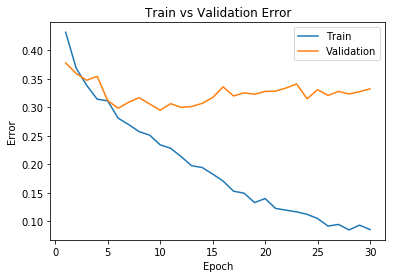

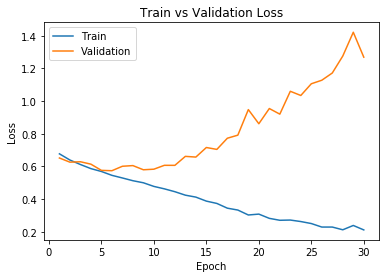

In [ ]:
model_path_large_16 = get_model_name("large", batch_size = 16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large_16)

4-A  Based on the results, default value with lr =0.01 and batch size of 64 will be used, since it creates a lowest validation error and loss. Also the graph makes the most sense since we can see cearly when the validation curve stops decreasing, which suggests the starting point(epoch) of overfitting so that we know when to stop training the model. Therefore I think this is a good starting point.

4-B

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.44475, Train loss: 0.6900203099250793 |Validation err: 0.4285, Validation loss: 0.680754292756319
Epoch 2: Train err: 0.419125, Train loss: 0.678190191745758 |Validation err: 0.413, Validation loss: 0.6741814017295837
Epoch 3: Train err: 0.39875, Train loss: 0.6658317875862122 |Validation err: 0.391, Validation loss: 0.6517764702439308
Epoch 4: Train err: 0.374125, Train loss: 0.6491540780067444 |Validation err: 0.4095, Validation loss: 0.6662181690335274
Epoch 5: Train err: 0.35675, Train loss: 0.6333453297615051 |Validation err: 0.353, Validation loss: 0.6291991733014584
Epoch 6: Train err: 0.33925, Train loss: 0.6163788948059082 |Validation err: 0.344, Validation loss: 0.6148867644369602
Epoch 7: Train err: 0.327875, Train loss: 0.6005767168998718 |Validation err: 0.3315, Validation loss: 0.6076090820133686
Epoch 8: Train err: 0.311875, Train loss: 0.5835636842250824 |Validation err: 0.

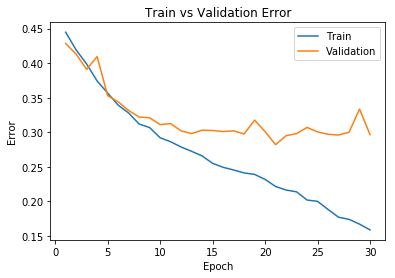

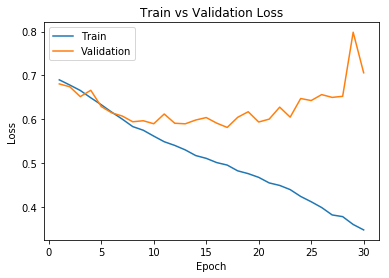

In [ ]:
model_path_large = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

4-C

Answer:

Since batch size  =16 creates noise, and batch size = 64 looks fine but may be too expensive, I will try batch size of 32 to accomodate for these weaknesses to see if it is the better choice of batch size.

4-D

In [ ]:
large_net = LargeNet()
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.447625, Train loss: 0.6850859241485596 |Validation err: 0.4095, Validation loss: 0.6715219219525655
Epoch 2: Train err: 0.385125, Train loss: 0.6621165516376495 |Validation err: 0.3725, Validation loss: 0.6446243997604127
Epoch 3: Train err: 0.361375, Train loss: 0.6363008983135223 |Validation err: 0.348, Validation loss: 0.6213002975970979
Epoch 4: Train err: 0.341375, Train loss: 0.6120481569766998 |Validation err: 0.345, Validation loss: 0.6242239929380871
Epoch 5: Train err: 0.3195, Train loss: 0.5915817145109177 |Validation err: 0.316, Validation loss: 0.593362948251149
Epoch 6: Train err: 0.299875, Train loss: 0.57114266872406 |Validation err: 0.335, Validation loss: 0.6284947045265682
Epoch 7: Train err: 0.297375, Train loss: 0.5610119928121566 |Validation err: 0.3115, Validation loss: 0.5843207183338347
Epoch 8: Train err: 0.283125, Train loss: 0.5430752960443497 |Validation err: 0

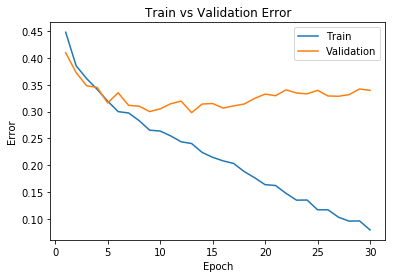

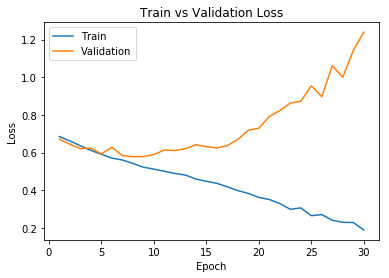

In [ ]:
model_path_large = get_model_name("large", batch_size=32, learning_rate=0.01, epoch=29)
plot_training_curve(model_path_large)

5-A  Validation err: 0.286, Validation loss: 0.5836452133953571, epoch 27

In [ ]:
net = SmallNet()
model_path = get_model_name(net.name, batch_size=64, learning_rate=0.01, epoch=27)
state = torch.load(model_path)
net.load_state_dict(state)

5-B 

Answer: SmallNet has the lowest validation error at epoch 27. It has a small validation loss as well, though not the smallest.

Validation err: 0.286, Validation loss: 0.5836452133953571, epoch 27

5-C

In [ ]:
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=64)
criterion = nn.BCEWithLogitsLoss()
print(evaluate(net, test_loader,criterion))

Files already downloaded and verified
Files already downloaded and verified
(0.4555, 0.6879156213253736)


5-D

Answer: It is noticable that the test error is higher than the validation error. This is because the test data set is not used during the entire process of the training of the neural network. Validation set is used during the training process for optimizing the best parameters values, so the trained model is also "trained" from the validation data. Once the network get a brand new set of data, which is the test data, it will likely produce a higher error/less accuracy.

5-E

Answer:

We use the test data at the very end because we want to judge the actual performance of our trained network. So we don't use any of the test data until we finish training. Otherwise the network will memorize and learn the test data as well, which will produce a biased accuracy/performance result. We want to use as little as possible as the test data because we only want to test the general performance of the model, if the data set is too big, it will just learn the test set and produce a fake performance result. Also we want to leave more data sets as training data and validation data, since these 3 types of datasets generally come from a single database.